<a href="https://colab.research.google.com/github/nsk31512/algoritms_python/blob/alg_ds_hw3/Algoritm_Hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [223]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [224]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    def _log_grad(self, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, self.w.T).flatten()+self.w0
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    def _optimize(self, X, target):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w = self.w-self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        self._optimize(X, target)
    def predict_proba(self, X):  
        '''
        Рассчёт вероятности
        '''
        score=X.dot(self.w.T).flatten()+self.w0
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

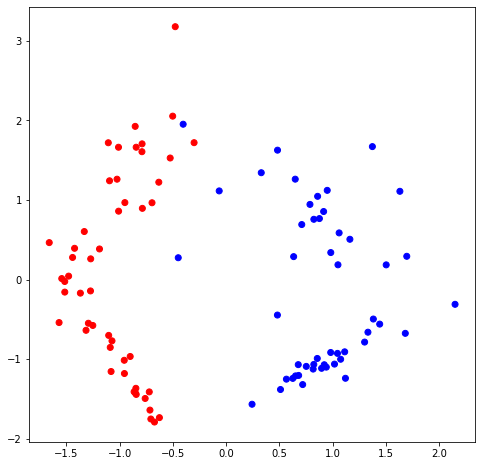

In [225]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [226]:
# перемешивание датасета
np.random.seed(42)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.75
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (75, 2)
Размер массива признаков тестовой выборки (25, 2)
Размер массива ответов для обучающей выборки (75,)
Размер массива ответов для тестовой выборки (25,)


#Порог 0,5

In [227]:
mod=logistic_regression()
mod.fit(X_train, y_train)

In [228]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [229]:
def logloss_report(X_train_, X_test_, mod_, lim = 0.5):
  y_predicted_test = mod_.predict(X_test_, lim)
  y_predicted_train = mod_.predict(X_train_, lim)

  # В качестве меры точности возьмем долю правильных ответов
  train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
  test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

  print(f"Итоговый вектор весов w: {mod.w}")
  print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
  print(f"Точность на тестовой выборке: {test_accuracy:.3f}\n")

  cofusion_fixed = confusion(y_predicted_test, y_test)

  precision = cofusion_fixed['TP'] / (cofusion_fixed['TP'] + cofusion_fixed['FP'])
  recall = cofusion_fixed['TP'] / (cofusion_fixed['TP'] + cofusion_fixed['FN'])
  FPR = cofusion_fixed['FP'] / (cofusion_fixed['FP'] + cofusion_fixed['TN'])
  TPR = recall
  print(f"Для порога по вероятности {lim} на тестовой выборке имеем: точность {precision}, "+
        f"полноту {recall}, FPR {FPR}, TPR {TPR}\n")
  
  bins_pos = (y_predicted_test > 0)
  bins_neg = (y_predicted_test == 0)
  num_pos, num_neg=np.sum(bins_pos), np.sum(bins_neg)
  print(f'{num_pos} объектов положительного класса, {num_neg} объектов негативного класса\n')

  TPR = np.concatenate([[0], np.cumsum(bins_neg)/num_neg])
  FPR = np.concatenate([[0], np.cumsum(bins_pos)/num_pos])
  print(f'TPR: {TPR};\n FPR: {FPR}\n')

  precision = np.cumsum(bins_neg) / (np.cumsum(bins_neg) + np.cumsum(bins_pos))
  recall = TPR
  print(f'Precision: {precision};\n Recall: {recall}\n')

  AUC_ROC = np.sum((FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1])/2)
  AUC_PR = np.sum(precision * (recall[1:]-recall[:-1]))

  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
  fig.set_size_inches(12, 6)
  
  ax1.plot(FPR, TPR) 
  ax1.set_title('AUC-PR')
  ax1.set_xlabel('FPR')
  ax1.set_ylabel('TPR')
  ax1.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
  
  
  ax2.plot(recall[1:], precision)
  ax2.set_title('AUC-PR')
  ax2.set_xlabel('recall')
  ax2.set_ylabel('precision')
  ax2.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')

Итоговый вектор весов w: [[ 0.28582324 -0.00309079]]
Точность на обучающей выборке: 96.000
Точность на тестовой выборке: 100.000

Для порога по вероятности 0.5 на тестовой выборке имеем: точность 1.0, полноту 1.0, FPR 0.0, TPR 1.0

15 объектов положительного класса, 10 объектов негативного класса

TPR: [0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.2 0.3 0.3 0.3 0.4 0.5 0.5 0.5 0.5 0.5
 0.5 0.6 0.7 0.7 0.8 0.9 0.9 1. ];
 FPR: [0.         0.06666667 0.13333333 0.13333333 0.2        0.26666667
 0.33333333 0.4        0.4        0.4        0.46666667 0.53333333
 0.53333333 0.53333333 0.6        0.66666667 0.73333333 0.8
 0.86666667 0.86666667 0.86666667 0.93333333 0.93333333 0.93333333
 1.         1.        ]

Precision: [0.         0.         0.33333333 0.25       0.2        0.16666667
 0.14285714 0.25       0.33333333 0.3        0.27272727 0.33333333
 0.38461538 0.35714286 0.33333333 0.3125     0.29411765 0.27777778
 0.31578947 0.35       0.33333333 0.36363636 0.39130435 0.375
 0.4       ];
 Recall:

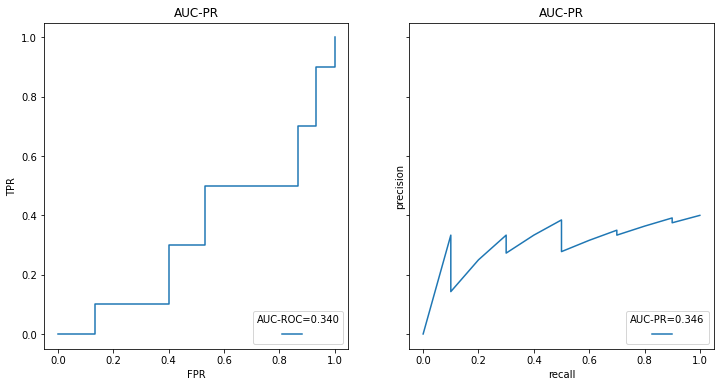

In [230]:
logloss_report(X_train, X_test, mod)

# Порог 0,4

Итоговый вектор весов w: [[ 0.28582324 -0.00309079]]
Точность на обучающей выборке: 54.667
Точность на тестовой выборке: 72.000

Для порога по вероятности 0.4 на тестовой выборке имеем: точность 0.6818181818181818, полноту 1.0, FPR 0.7, TPR 1.0

22 объектов положительного класса, 3 объектов негативного класса

TPR: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.33333333 0.33333333 0.66666667 0.66666667
 0.66666667 1.        ];
 FPR: [0.         0.04545455 0.09090909 0.13636364 0.18181818 0.22727273
 0.27272727 0.31818182 0.36363636 0.40909091 0.45454545 0.5
 0.54545455 0.59090909 0.63636364 0.68181818 0.72727273 0.77272727
 0.81818182 0.86363636 0.86363636 0.90909091 0.90909091 0.95454545
 1.         1.        ]

Precision: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

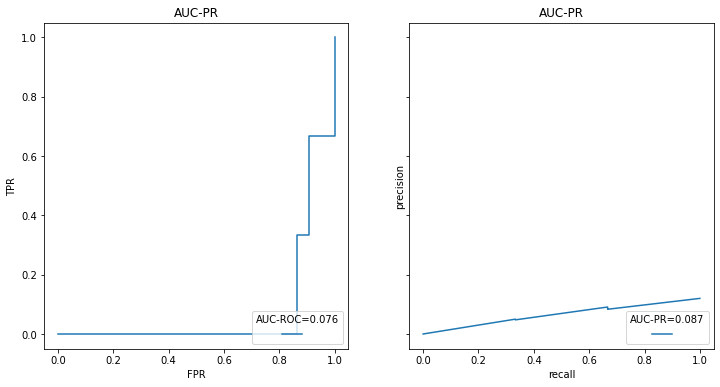

In [231]:
logloss_report(X_train, X_test, mod, 0.4)

# Порог 0.6

Итоговый вектор весов w: [[ 0.28582324 -0.00309079]]
Точность на обучающей выборке: 58.667
Точность на тестовой выборке: 44.000

Для порога по вероятности 0.6 на тестовой выборке имеем: точность 1.0, полноту 0.06666666666666667, FPR 0.0, TPR 0.06666666666666667

1 объектов положительного класса, 24 объектов негативного класса

TPR: [0.         0.04166667 0.08333333 0.125      0.125      0.16666667
 0.20833333 0.25       0.29166667 0.33333333 0.375      0.41666667
 0.45833333 0.5        0.54166667 0.58333333 0.625      0.66666667
 0.70833333 0.75       0.79166667 0.83333333 0.875      0.91666667
 0.95833333 1.        ];
 FPR: [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]

Precision: [1.         1.         1.         0.75       0.8        0.83333333
 0.85714286 0.875      0.88888889 0.9        0.90909091 0.91666667
 0.92307692 0.92857143 0.93333333 0.9375     0.94117647 0.94444444
 0.94736842 0.95       0.95238095 0.95454545 0.95652174 0.95833333
 0.96 

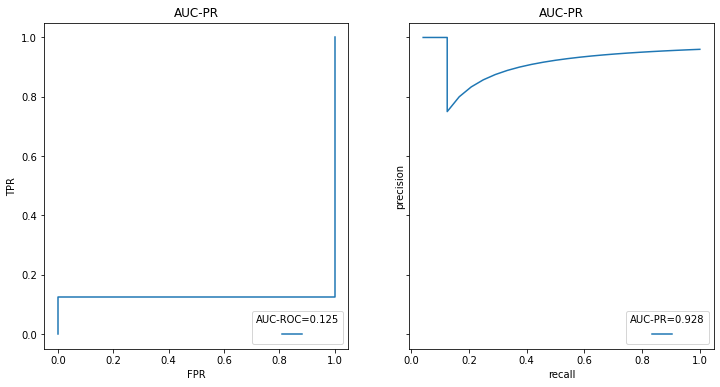

In [232]:
logloss_report(X_train, X_test, mod, 0.6)